## Analysis of Loan duration and late returns across media types
This notebook is used to explore possible correlations between loan duration and late returns across media types.

Most of the analysis is done with media types with at least 1000 borrowings. (Adjust the `MIN_BORROWINGS_PER_MEDIA_TYPE` variable in `03_data_cleaning.ipynb`)

Initialization
- import all dependencies
- read all borrowings from "borrowings" csv-file

In [3]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from utils import setup_pandas, setup_plotting, log_pearson_spearman

input_file = Path('../dat/processed/borrowings_2019_2025_cleaned.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(1901023, 21)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,...,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer,source_year,late_bool,open_days_leihdauer,max_allowed_open_days,weird_loan
0,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,...,NaN,9783831904525,NaN,MPA,50.0,2019,False,0.0,56,False
1,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,...,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0,2019,False,0.0,56,False
2,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,...,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0,2019,False,0.0,56,False
3,56574,2019-01-07 00:00:00,2019-02-09 12:14:54,33.0,0,Nein,0.0,eslfantasy,Belletristik,15138046,...,"Sapkowski, Andrzej",9783423247542,Fantasy,A12,10445.0,2019,False,0.0,28,False
4,1000896,2019-01-08 00:00:00,2019-01-28 11:04:21,20.0,0,Nein,0.0,esach,Sachbuch,18506705,...,NaN,9783742601445,Lernhilfe - Deutsch,MZUL,1000014.0,2019,False,0.0,28,False


## Overview
show the amount of borrowings per category

In [4]:
data_frame["Medientyp"].unique()
data_frame["Medientyp"].value_counts()

Medientyp
Kinder u. Jugendbuch           622940
Sachbuch                       315324
DVD                            243461
Belletristik                   229073
Kinder u. Jugend-CD            162848
Comic                          120475
Hörbuch                         55468
Musik-CD                        53130
Fremdsprachige Belletristik     24088
Tonie                           18206
Spiele                          17779
Zeitschriften                   11993
Konsolenspiel                    6939
Sprachkurse                      6261
Sonstiges                        5611
Blu-Ray                          2845
Kamishibai                       1345
Bibliothek der Dinge             1080
Lesehaus                          659
Bestellt über Medienwelten        529
Makerboxen                        477
CD-ROM                            393
Sach-CD                            99
Name: count, dtype: int64

## First look at Media Types in combination with late returns
Now we want to examine correlations between media types and borrowings that were returned late. As a first step, we analyze the percentage of items that were returned late.

In [7]:
def getLateBorrowingsTable(input_data_frame):
    late_borrowings_per_type = []
    for media_type, media_type_group in input_data_frame.groupby("Medientyp"):
        amount_of_total_entries = len(media_type_group)
        amount_of_late_entries = (media_type_group["Verspätet"] == "Ja").sum()
        percent_late = amount_of_late_entries / amount_of_total_entries * 100

        late_borrowings_per_type.append({
         "Medientyp": media_type,
         "Anzahl_Ausleihen": amount_of_total_entries,
         "Anzahl_verspaetet": amount_of_late_entries,
         "Prozent_verspaetet": percent_late
        })

    late_borrowings_per_type_table = (
        pd.DataFrame(late_borrowings_per_type)
        .sort_values("Prozent_verspaetet", ascending=False)
        .reset_index(drop=True)
    )
    return late_borrowings_per_type_table

overview_table = getLateBorrowingsTable(data_frame)

display(overview_table)

,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Sachbuch,315324,16951,5.375741
1,Fremdsprachige Belletristik,24088,1099,4.562438
2,Kinder u. Jugendbuch,622940,27598,4.430282
3,Zeitschriften,11993,432,3.602101
4,Comic,120475,3469,2.879436
5,Belletristik,229073,5967,2.604846


## Identifying Indicators for Late Returns

The next step is to find good indicators for late returns by analyzing loan duration characteristics and their relationship to overdue behavior across different media types. The table below summarizes key statistics per media type. (boxplots for visualization)

### Column Descriptions

- **mean**: Average loan duration (in days).
- **median**: Median loan duration
- **p75 / p90 / p95**: Upper quantiles of the loan duration distribution, describing long borrowing periods.
- **late_rate_percent**:  Share of borrowings returned late.
- **median_late**: Median loan duration for borrowings that were returned late. Indicates how long overdue items are typically kept.
- **median_on_time**: Median loan duration for borrowings returned on time. Baseline for regular borrowing behavior.
- **delta_median**: Severity of late returns. Difference between late and on-time median loan duration. Highlights whether longer borrowing durations are associated with late returns.


<Figure size 1000x600 with 0 Axes>

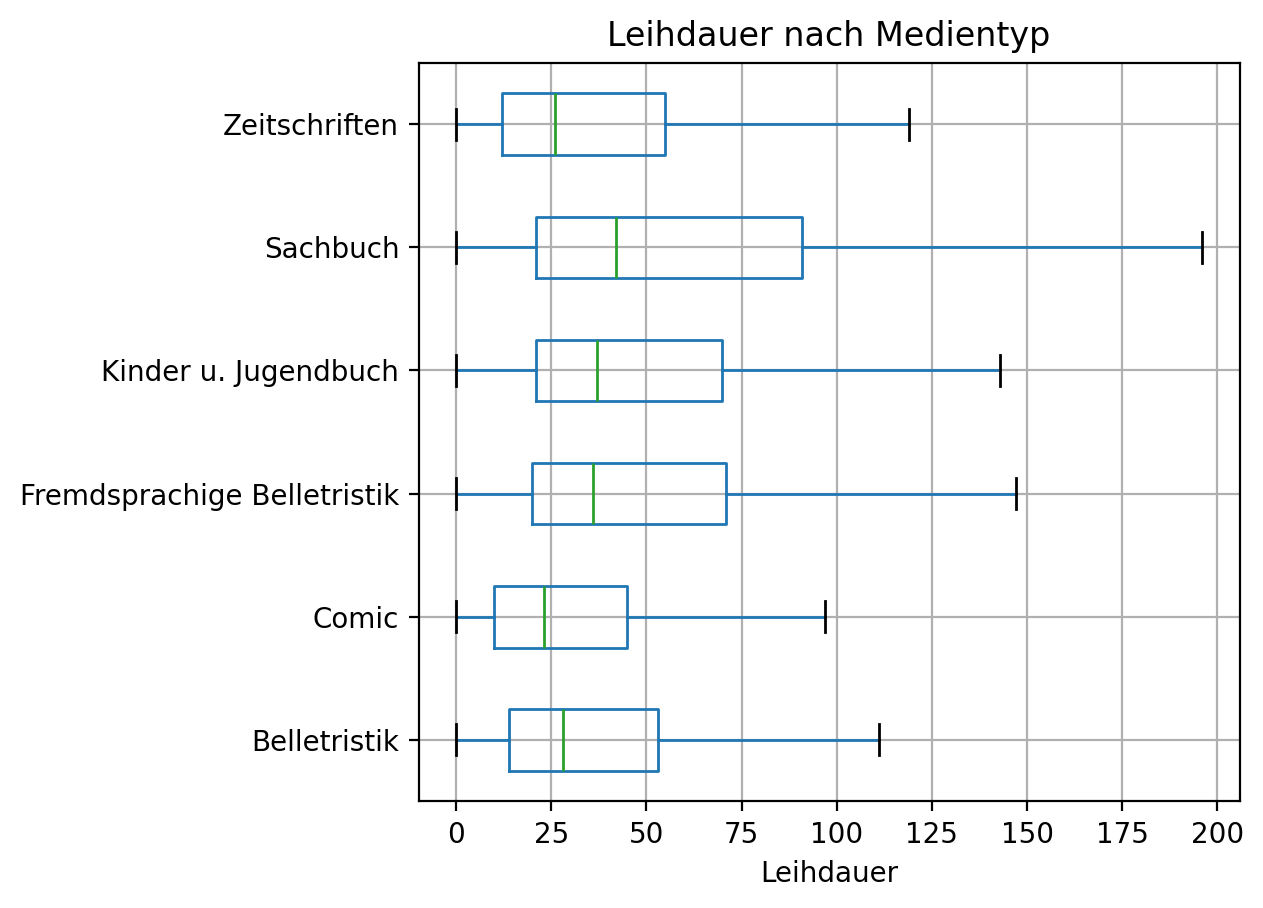

,Medientyp,mean,median,p75,p90,p95,late_rate_percent,median_late,median_on_time,delta_median
5,Zeitschriften,43.443842,26.0,55.0,107.0,160.0,3.602101,93.5,25.0,68.5
4,Sachbuch,66.758093,42.0,91.0,167.0,202.0,5.375741,98.0,41.0,57.0
2,Fremdsprachige Belletristik,55.515817,36.0,71.0,129.0,175.0,4.562438,81.0,35.0,46.0
1,Comic,35.817398,23.0,45.0,83.0,120.0,2.879436,52.0,22.0,30.0
0,Belletristik,42.564789,28.0,53.0,96.0,135.0,2.604846,55.0,27.0,28.0
3,Kinder u. Jugendbuch,54.338946,37.0,70.0,120.0,164.0,4.430282,60.0,36.0,24.0


In [8]:
leihdauer_stats = (
    data_frame
    .groupby("Medientyp")["Leihdauer"]
    .agg(
        mean="mean",
        median="median",
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    )
    .reset_index()
)

late_rate = (
    data_frame
    .groupby("Medientyp")["Verspätet"]
    .apply(lambda x: (x == "Ja").mean() * 100)
    .rename("late_rate_percent")
)

leihdauer_by_late = (
    data_frame
    .groupby(["Medientyp", "Verspätet"])["Leihdauer"]
    .median()
    .unstack()
    .rename(columns={"Ja": "median_late", "Nein": "median_on_time"})
)

leihdauer_by_late["delta_median"] = (
        leihdauer_by_late["median_late"]
        - leihdauer_by_late["median_on_time"]
)

media_type_table = (
    leihdauer_stats
    .set_index("Medientyp")
    .join(late_rate)
    .join(leihdauer_by_late)
    .reset_index()
    .sort_values("delta_median", ascending=False)
)

order = media_type_table["Medientyp"].tolist()

plt.figure(figsize=(10, 6))
data_frame.boxplot(
    column="Leihdauer",
    by="Medientyp",
    vert=False,
    grid=True,
    showfliers=False
)
plt.suptitle("")
plt.title("Leihdauer nach Medientyp")
plt.xlabel("Leihdauer")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(media_type_table)


## Takeaways
- across all media categories, late returns are associated with longer loan durations
- in some categories extended usage periods can be considered as a relevant risk signal for late returns (categories with high "delta_median")
- in categories with low "Delta_Median", this relationship is much less pronounced, suggesting that late returns there are driven by different underlying factors.

So there is a correlation between loan duration and late returns. In some categories its more pronounced.
To show this correlation we can look at the following plot (over all categories)

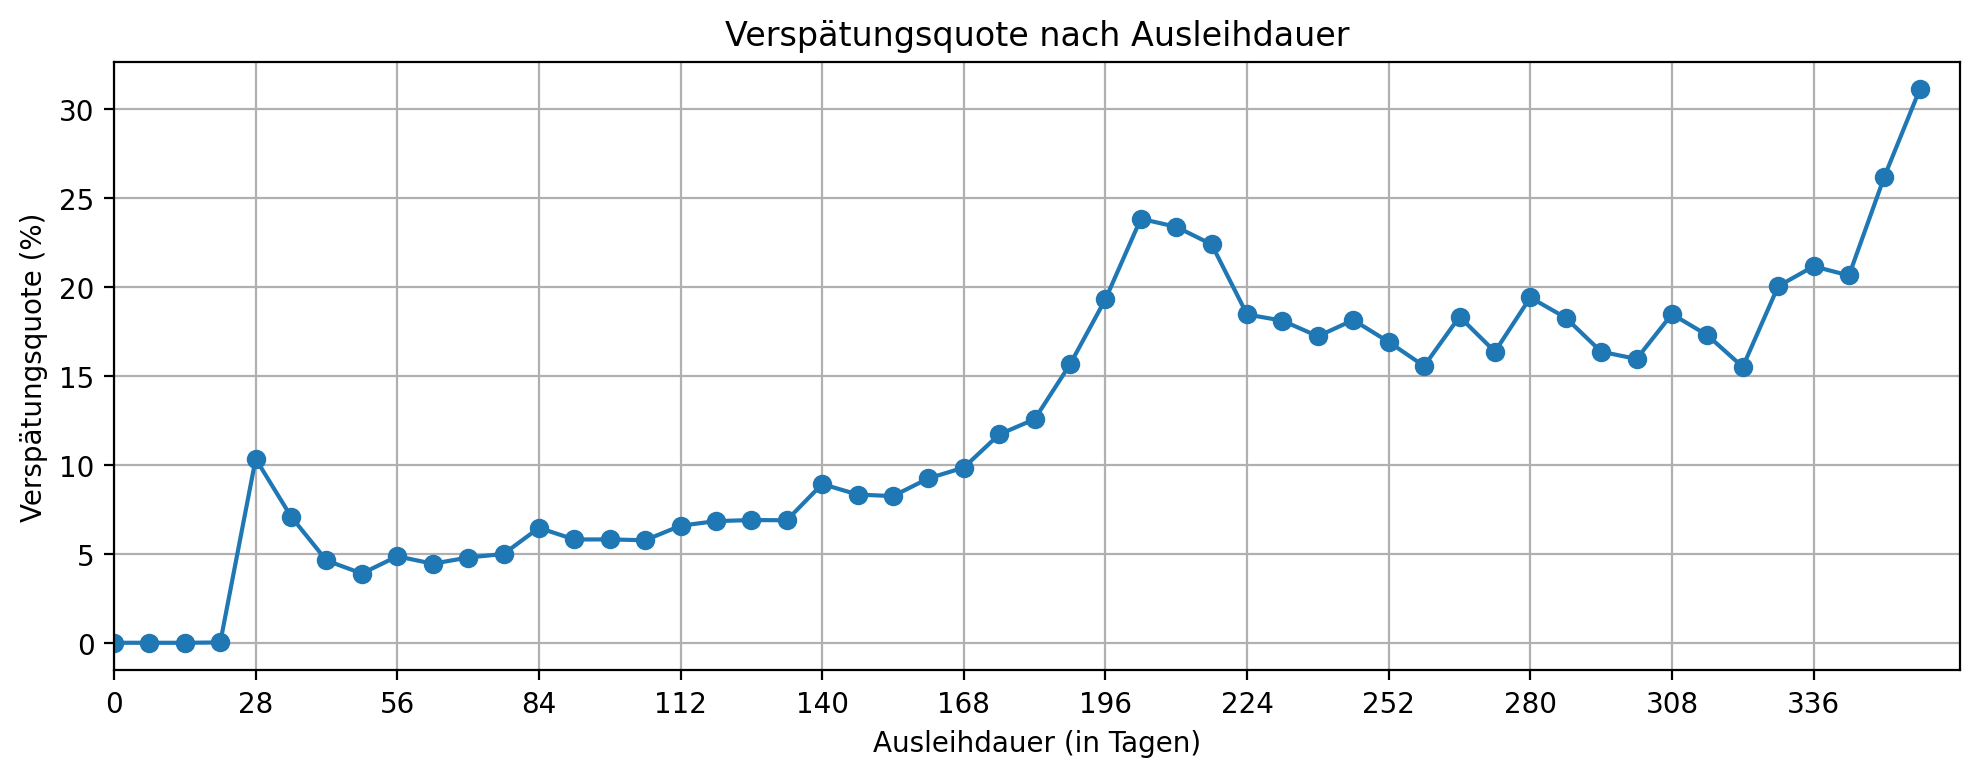

In [9]:
all_data_copy = data_frame.copy()

all_data_copy["duration_bin_7d"] = pd.cut(
    all_data_copy["Leihdauer"],
    bins=range(0, 366, 7),
    include_lowest=True
)

late_rate_7d = (
    all_data_copy.groupby("duration_bin_7d", observed=False)["late_bool"]
    .mean()
    * 100
)

x_vals = [interval.left for interval in late_rate_7d.index]
plt.figure(figsize=(10, 4))
plt.plot(x_vals, late_rate_7d.values, marker="o")

plt.xlabel("Ausleihdauer (in Tagen)")
plt.ylabel("Verspätungsquote (%)")
plt.title("Verspätungsquote nach Ausleihdauer")

plt.xticks(np.arange(0, max(x_vals) + 1, 28))
plt.xlim(0, 365)

plt.grid(True)
plt.tight_layout()
plt.show()


We can see that a longer loan duration leads to a higher delay rate. In some media types, this correlation is more pronounced (as shown in the table)

## Identifying correlations for properties of media types

To find correlations between properties of media types and late rate we look at some scatter plots.

In [10]:
media_type_table_copy = media_type_table.copy()

counts = data_frame.groupby("Medientyp").size().rename("n_loans")
media_type_table_copy = media_type_table_copy.merge(counts, on="Medientyp", how="left")

media_type_table_copy["size"] = 50 + 400 * np.sqrt(media_type_table_copy["n_loans"] / media_type_table_copy["n_loans"].max())

figure = px.scatter(
    media_type_table_copy,
    x="mean",
    y="late_rate_percent",
    size="size",
    hover_name="Medientyp",
    hover_data={
        "n_loans": True,
        "mean": ":.2f",
        "late_rate_percent": ":.2f",
        "median": ":.2f",
        "delta_median": ":.2f",
        "size": False
    },
    labels={
        "mean": "Mean loan duration (days)",
        "late_rate_percent": "Late rate (%)",
        "n_loans": "amount of loans",
        "delta_median": "median(late) - median(on time"
    },
    title="Mean Leihdauer vs Late returns",
    trendline="ols"
)

figure.update_traces(marker=dict(opacity=0.75))
figure.update_layout(
    xaxis_title="Mean loan duration (days)",
    yaxis_title="Late rate (%)",
    width=600,
    height=600,
)

figure.show()

log_pearson_spearman(media_type_table_copy, "mean", "late_rate_percent")

mean vs late_rate_percent (n=6)
Pearson  r   = 0.9474   p-value ("null hypothesis: no correlation") = 0.00408
Spearman rho = 0.9429   p-value ("null hypothesis: no correlation") = = 0.0048


### MIN_BORROWINGS_PER_MEDIA_TYPE = 1000
We see that there seems to be no correlation across media types. There is one clear outlier, **"Bibliothek der Dinge"**, which has a very high late rate but a very low median loan duration. However, with a threshold of 1,000 loans per media type, the number of loans per category may still be too small for stable estimates.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson r = -0.0509, p = 0.841
- Spearman rho = 0.1331, p = 0.598

### MIN_BORROWINGS_PER_MEDIA_TYPE = 5000
We increase the minimum number of loans to 5,000 per media type.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson r = 0.7192, p = 0.00374
- Spearman rho = 0.6264, p = 0.0165

With the increased threshold, we observe a fairly strong and approximately linear relationship between mean loan duration and late rate. This is consistent with the plot shown earlier across all media types. Loan duration therefore seems to be an indicator for late returns (at the media-type level).


In [11]:
input_data_frame = media_type_table_copy.copy()
input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())

fig = px.scatter(
    input_data_frame, x="delta_median", y="late_rate_percent", size="size",
    hover_name="Medientyp",
    hover_data={"n_loans":True, "delta_median":":.1f", "late_rate_percent":":.2f", "mean":":.1f", "size":False},
    labels={"delta_median":"delta_median (late - on time) days", "late_rate_percent":"Late rate (%)"},
    title="Late rate vs delta_median",
    trendline="ols"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.update_layout(width=650, height=600)
fig.show()

log_pearson_spearman(input_data_frame, "delta_median", "late_rate_percent")

delta_median vs late_rate_percent (n=6)
Pearson  r   = 0.3939   p-value ("null hypothesis: no correlation") = 0.44
Spearman rho = 0.3714   p-value ("null hypothesis: no correlation") = = 0.468


Across media types, there is no significant correlation between the median difference in loan duration (late vs. on-time) and the late-return rate.
Thus, the magnitude of the loan-duration difference in late cases (as a measure of “severity”) does not appear to be related to how frequently late returns occur.

In [12]:
input_data_frame = media_type_table_copy.copy()
input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())

fig = px.scatter(
    input_data_frame, x="p90", y="late_rate_percent", size="size",
    hover_name="Medientyp",
    hover_data={"n_loans":True, "p90":":.1f", "late_rate_percent":":.2f", "mean":":.1f", "size":False},
    labels={"p90":"P90 loan duration (days)", "late_rate:percent":"Late rate (%)"},
    title="Late rate vs long-tail duration (P90)",
    trendline="ols"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.update_layout(width=650, height=600)
fig.show()

log_pearson_spearman(input_data_frame, "p90", "late_rate_percent")

p90 vs late_rate_percent (n=6)
Pearson  r   = 0.9408   p-value ("null hypothesis: no correlation") = 0.00516
Spearman rho = 0.9429   p-value ("null hypothesis: no correlation") = = 0.0048


Across media types, there is a significant positive association between the P90 loan duration (as a measure of long-tail loan length) and the late-return rate.
This means that media types with particularly long upper-tail loan durations tend to have higher late rates.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson r = 0.7192, p = 0.00374
- Spearman rho = 0.6264, p = 0.0165

Note: This correlation is only observed when setting MIN_BORROWINGS_PER_MEDIA_TYPE to 5,000 or higher. When including media types with fewer than 5,000 loans, several clear outliers appear and weaken the relationship. These outlier media types are the same ones identified in the earlier comparison of mean loan duration and late rate across media types.